In [1]:
from google.colab import auth
auth.authenticate_user()

import os

# TODO: Enter your own Google Cloud Project name here
os.environ["GCLOUD_PROJECT"] = "daring-runway-287322"
!export GCLOUD_PROJECT=daring-runway-287322

# Dataset Parser

In [2]:
class FLAGS:
    test_directory = 'test/images/*/*/*/'
    output_directory = 'gs://khch-gldv2-full/tfrecord/'
    test_csv_path = 'test.csv'
    num_shards_per_part = 2 # per TAR file
    seed = 0

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import os

import numpy as np
import pandas as pd
import tensorflow as tf

_FILE_IDS_KEY = 'file_ids'
_IMAGE_PATHS_KEY = 'image_paths'
_LABELS_KEY = 'labels'
_TEST_SPLIT = 'test'
_TRAIN_SPLIT = 'train'
_VALIDATION_SPLIT = 'validation'


def _get_all_image_files_and_labels(name, csv_path, image_dir):
  """Process input and get the image file paths, image ids and the labels.

  Args:
    name: 'train' or 'test'.
    csv_path: path to the Google-landmark Dataset csv Data Sources files.
    image_dir: directory that stores downloaded images.
  Returns:
    image_paths: the paths to all images in the image_dir.
    file_ids: the unique ids of images.
    labels: the landmark id of all images. When name='test', the returned labels
      will be an empty list.
  Raises:
    ValueError: if input name is not supported.
  """
  image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
  file_ids = [os.path.basename(os.path.normpath(f))[:-4] for f in image_paths]
  if name == _TRAIN_SPLIT:
    with tf.io.gfile.GFile(csv_path, 'rb') as csv_file:
      df = pd.read_csv(csv_file)
    df = df.set_index('id')
    labels = [int(df.loc[fid]['landmark_id']) for fid in file_ids]
  elif name == _TEST_SPLIT:
    labels = []
  else:
    raise ValueError('Unsupported dataset split name: %s' % name)
  return image_paths, file_ids, labels


def _process_image(filename):
  """Process a single image file.

  Args:
    filename: string, path to an image file e.g., '/path/to/example.jpg'.

  Returns:
    image_buffer: string, JPEG encoding of RGB image.
    height: integer, image height in pixels.
    width: integer, image width in pixels.
  Raises:
    ValueError: if parsed image has wrong number of dimensions or channels.
  """
  # Read the image file.
  with tf.io.gfile.GFile(filename, 'rb') as f:
    image_data = f.read()

  # Decode the RGB JPEG.
  image = tf.io.decode_jpeg(image_data, channels=3)

  # Check that image converted to RGB
  if len(image.shape) != 3:
    raise ValueError('The parsed image number of dimensions is not 3 but %d' %
                     (image.shape))
  height = image.shape[0]
  width = image.shape[1]
  if image.shape[2] != 3:
    raise ValueError('The parsed image channels is not 3 but %d' %
                     (image.shape[2]))

  return image_data, height, width


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _convert_to_example(file_id, image_buffer, height, width, label=None):
  """Build an Example proto for the given inputs.

  Args:
    file_id: string, unique id of an image file, e.g., '97c0a12e07ae8dd5'.
    image_buffer: string, JPEG encoding of RGB image.
    height: integer, image height in pixels.
    width: integer, image width in pixels.
    label: integer, the landmark id and prediction label.

  Returns:
    Example proto.
  """
  colorspace = 'RGB'
  channels = 3
  image_format = 'JPEG'
  features = {
      'image/height': _int64_feature(height),
      'image/width': _int64_feature(width),
      'image/colorspace': _bytes_feature(colorspace.encode('utf-8')),
      'image/channels': _int64_feature(channels),
      'image/format': _bytes_feature(image_format.encode('utf-8')),
      'image/id': _bytes_feature(file_id.encode('utf-8')),
      'image/encoded': _bytes_feature(image_buffer)
  }
  if label is not None:
    features['image/class/label'] = _int64_feature(label)
  example = tf.train.Example(features=tf.train.Features(feature=features))

  return example


def _write_tfrecord(output_prefix, image_paths, file_ids, labels,
                    part_idx, total_parts, num_shards_per_part):
  """Read image files and write image and label data into TFRecord files.

  Args:
    output_prefix: string, the prefix of output files, e.g. 'train'.
    image_paths: list of strings, the paths to images to be converted.
    file_ids: list of strings, the image unique ids.
    labels: list of integers, the landmark ids of images. It is an empty list
      when output_prefix='test'.

  Raises:
    ValueError: if the length of input images, ids and labels don't match
  """
  if output_prefix == _TEST_SPLIT:
    labels = [None] * len(image_paths)
  if not len(image_paths) == len(file_ids) == len(labels):
    raise ValueError('length of image_paths, file_ids, labels shoud be the' +
                     ' same. But they are %d, %d, %d, respectively' %
                     (len(image_paths), len(file_ids), len(labels)))

  spacing = np.linspace(0, len(image_paths), num_shards_per_part + 1, dtype=np.int)

  for shard in range(num_shards_per_part):
    output_file = os.path.join(
        FLAGS.output_directory,
        '%s-%.5d-of-%.5d' % (output_prefix,
                             part_idx * num_shards_per_part + shard,
                             total_parts * num_shards_per_part))
    writer = tf.io.TFRecordWriter(output_file)
    print('    - Processing shard ', shard, ' and writing file ', output_file)
    for i in range(spacing[shard], spacing[shard + 1]):
      image_buffer, height, width = _process_image(image_paths[i])
      example = _convert_to_example(file_ids[i], image_buffer, height, width,
                                    labels[i])
      writer.write(example.SerializeToString())
    writer.close()


def _build_test_tfrecord_dataset(csv_path, image_dir, part_idx, total_parts):
  """Build a TFRecord dataset for the 'test' split.

  Args:
    csv_path: path to the 'test' Google-landmark Dataset csv Data Sources files.
    image_dir: directory that stores downloaded images.

  Returns:
    Nothing. After the function call, sharded TFRecord files are materialized.
  """
  image_paths, file_ids, labels = _get_all_image_files_and_labels(
      _TEST_SPLIT, csv_path, image_dir)
  _write_tfrecord(_TEST_SPLIT, image_paths, file_ids, labels,
                  part_idx, total_parts, FLAGS.num_shards_per_part)


def build_test_dataset(part_idx, total_parts):
  _build_test_tfrecord_dataset(FLAGS.test_csv_path, FLAGS.test_directory,
                               part_idx, total_parts)

In [4]:
import os
import glob
import hashlib
from datetime import datetime
import subprocess
import shutil
from urllib.request import urlretrieve


def download_to_gcs(split, indices):
    csv_url = f'https://s3.amazonaws.com/google-landmark/metadata/{split}.csv'
    print('  - Downloading csv {}...'.format(csv_url), end=' ')
    begin = datetime.now()
    urlretrieve(csv_url, f'{split}.csv')
    print('Done in', datetime.now() - begin)
    
    tar_format_url = 'https://s3.amazonaws.com/google-landmark/{split}/images_{idx:03d}.tar'
    md5_format_url = 'https://s3.amazonaws.com/google-landmark/md5sum/{split}/md5.images_{idx:03d}.txt'
    
    for idx in indices:
        print(f'{split}-{idx:03d}:')
        
        archive_url = tar_format_url.format(split=split, idx=idx)
        print('  - Downloading archive {}...'.format(archive_url), end=' ')
        begin = datetime.now()
        urlretrieve(archive_url, 'tmp_images.tar')
        print('Done in', datetime.now() - begin)

        checksum_url = md5_format_url.format(split=split, idx=idx)
        print('  - Downloading md5 checksum {}...'.format(checksum_url), end=' ')
        begin = datetime.now()
        urlretrieve(checksum_url, 'tmp_md5.txt')
        print('Done in', datetime.now() - begin)

        print('  - Calculating MD5 checksum...', end=' ')
        md5sum_call = subprocess.Popen(['md5sum', 'tmp_images.tar'], stdout=subprocess.PIPE)
        md5sum, _ = md5sum_call.communicate()
        md5sum_call.wait()
        md5sum = md5sum.decode('ascii').split()[0]

        with open('tmp_md5.txt', 'r') as f:
            md5sum_expected = f.read().split()[0]

        if not md5sum == md5sum_expected:
            print('Mismatch, the index will be added to `failed_indices.txt')
            raise ValueError
        else:
            print('Matched')

        print('  - Extracting archive to images folder...', end=' ')
        begin = datetime.now()
        if not os.path.isdir(f'{split}/images/'):
            os.makedirs(f'{split}/images/')
        extraction_task = subprocess.Popen(['tar', '-xf', './tmp_images.tar', '-C', f'{split}/images/'])
        extraction_task.wait()
        print('Done in', datetime.now() - begin)

        print('  - Building TFRecrod and extracting to GCS:')
        begin = datetime.now()
        if split == 'test':
            build_test_dataset(idx, len(indices))
        else:
            raise ValueError('split should be test')
        print('    Done in', datetime.now() - begin)
        
        print('  - Cleaning up working directory...', end=' ')
        begin = datetime.now()
        os.remove('tmp_images.tar')
        os.remove('tmp_md5.txt')
        shutil.rmtree(f'{split}/')
        print('Done in', datetime.now() - begin)
    
    print('Finished successfully')

# Convert Test Set to GCS

In [5]:
download_to_gcs('test', [idx for idx in range(20)])

  - Downloading csv https://s3.amazonaws.com/google-landmark/metadata/test.csv... Done in 0:00:00.746841
test-000:
  - Downloading archive https://s3.amazonaws.com/google-landmark/test/images_000.tar... Done in 0:00:13.374682
  - Downloading md5 checksum https://s3.amazonaws.com/google-landmark/md5sum/test/md5.images_000.txt... Done in 0:00:00.264474
  - Calculating MD5 checksum... Matched
  - Extracting archive to images folder... Done in 0:00:02.118159
  - Building TFRecrod and extracting to GCS:
    - Processing shard  0  and writing file  gs://khch-gldv2-full/tfrecord/test-00000-of-00040
    - Processing shard  1  and writing file  gs://khch-gldv2-full/tfrecord/test-00001-of-00040
    Done in 0:00:29.520929
  - Cleaning up working directory... Done in 0:00:00.316731
test-001:
  - Downloading archive https://s3.amazonaws.com/google-landmark/test/images_001.tar... Done in 0:00:14.171934
  - Downloading md5 checksum https://s3.amazonaws.com/google-landmark/md5sum/test/md5.images_001.t

# Inspect the converted dataset

In [7]:
import tensorflow as tf


def retrieve_tfrecord_filenames(tfrecord_dir, basename, shards):
    """Generates filenames of sharded TFRecord dataset"""
    filenames = []
    for shard_index in range(shards):
        shard_filename = os.path.join(
            tfrecord_dir, f'{basename}-{shard_index:05d}-of-{shards:05d}')
        filenames.append(shard_filename)
    return filenames

In [24]:
import os
import functools
from tensorflow.io import FixedLenFeature


class _DataAugmentationParams(object):
    """Default parameters for augmentation."""
    # The following are used for training.
    min_object_covered = 0.1
    aspect_ratio_range_min = 3. / 4
    aspect_ratio_range_max = 4. / 3
    area_range_min = 0.08
    area_range_max = 1.0
    max_attempts = 100
    update_labels = False
    # 'central_fraction' is used for central crop in inference.
    central_fraction = 0.875

    random_reflection = False
    input_rows = 321
    input_cols = 321


def _normalize_images(images, pixel_value_scale=0.5, pixel_value_offset=0.5):
    """Normalize pixel values in image.
    Output is computed as
    normalized_images = (images - pixel_value_offset) / pixel_value_scale.
    Args:
      images: `Tensor`, images to normalize.
      pixel_value_scale: float, scale.
      pixel_value_offset: float, offset.
    Returns:
      normalized_images: `Tensor`, normalized images.
    """
    images = tf.cast(images, tf.float32)
    normalized_images = tf.math.divide(
        tf.subtract(images, pixel_value_offset), pixel_value_scale)
    return normalized_images


def _imagenet_crop(image):
    """Imagenet-style crop with random bbox and aspect ratio.
    Args:
      image: a `Tensor`, image to crop.
    Returns:
      cropped_image: `Tensor`, cropped image.
    """
    params = _DataAugmentationParams()
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    (bbox_begin, bbox_size, _) = tf.image.sample_distorted_bounding_box(
            tf.shape(image),
            bounding_boxes=bbox,
            min_object_covered=params.min_object_covered,
            aspect_ratio_range=(params.aspect_ratio_range_min,
                                params.aspect_ratio_range_max),
            area_range=(params.area_range_min, params.area_range_max),
            max_attempts=params.max_attempts,
            use_image_if_no_bounding_boxes=True)
    cropped_image = tf.slice(image, bbox_begin, bbox_size)
    cropped_image.set_shape([None, None, 3])

    cropped_image = tf.image.resize(
            cropped_image,
            [params.input_rows, params.input_cols],
            method='area')
    if params.random_reflection:
        cropped_image = tf.image.random_flip_left_right(cropped_image)

    return cropped_image


def _parse_function(example, name_to_features, image_size, augmentation):
    """
    Parse a single TFExample to get the image and label and process the image.
    Args:
      example: a `TFExample`.
      name_to_features: a `dict`. The mapping from feature names to its type.
      image_size: an `int`. The image size for the decoded image, on each side.
      augmentation: a `boolean`. True if the image will be augmented.
    Returns:
      image: a `Tensor`. The processed image.
      label: a `Tensor`. The ground-truth label.
    """
    parsed_example = tf.io.parse_single_example(example, name_to_features)
    # Parse to get image.
    image = parsed_example['image/encoded']
    image = tf.io.decode_jpeg(image)
    image = _normalize_images(
            image, pixel_value_scale=128.0, pixel_value_offset=128.0)
    if augmentation:
        image = _imagenet_crop(image)
    else:
        image = tf.image.resize(image, [image_size[0], image_size[1]])
        image.set_shape([image_size[0], image_size[1], 3])

    # Parse to get label.
    file_name = parsed_example['image/id']

    return image, file_name


def get_gld_parser(image_size=(512, 512), imagenet_augmentation=False):
    """Parses the Google Landmark Dataset into (image, sparse_label) format.
    """
    # Create a description of the features.
    feature_description = {
        'image/height': FixedLenFeature([], tf.int64, default_value=0),
        'image/width': FixedLenFeature([], tf.int64, default_value=0),
        'image/channels': FixedLenFeature([], tf.int64, default_value=0),
        'image/format': FixedLenFeature([], tf.string, default_value=''),
        'image/id': FixedLenFeature([], tf.string, default_value=''),
        'image/filename': FixedLenFeature([], tf.string, default_value=''),
        'image/encoded': FixedLenFeature([], tf.string, default_value=''),
        'image/class/label': FixedLenFeature([], tf.int64, default_value=0),
    }
    customized_parse_func = functools.partial(
          _parse_function,
          name_to_features=feature_description,
          image_size=image_size,
          augmentation=imagenet_augmentation
    )
    return customized_parse_func

In [25]:
filenames = retrieve_tfrecord_filenames('gs://khch-gldv2-full/tfrecord/',
                                        'test', 40)
test_dataset = tf.data.TFRecordDataset(filenames)

In [26]:
test_dataset = test_dataset.map(get_gld_parser(
    image_size=(512, 512),
    imagenet_augmentation=False
))

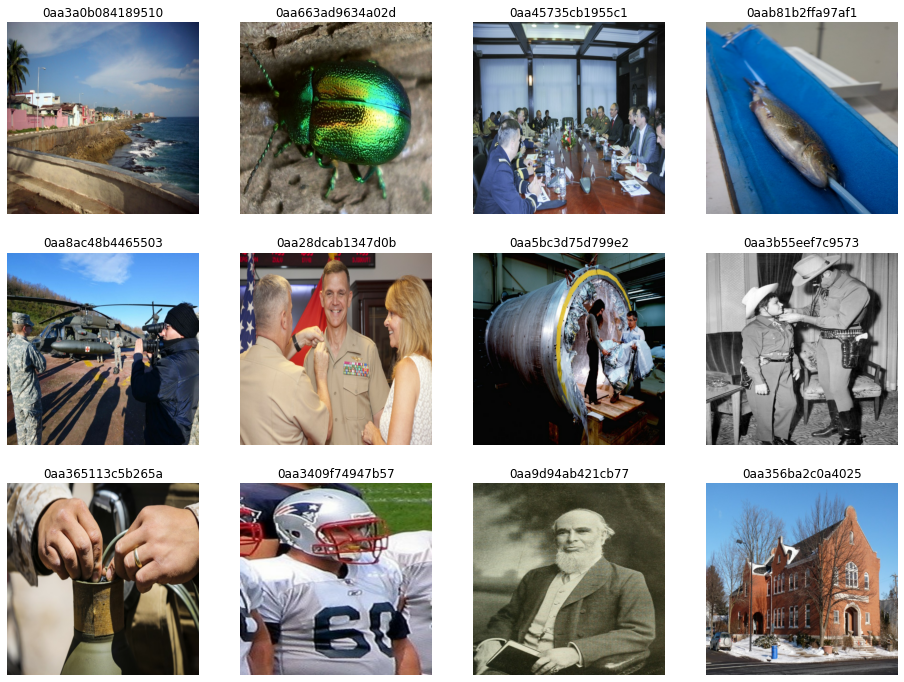

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))

count = 0
for item in test_dataset:
  img = (128. * item[0].numpy() + 128.).astype(np.uint8)
  img_id = item[1].numpy().decode('ascii')

  plt.subplot(3, 4, count + 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(img_id)
  count += 1
  if count >= 12:
    break